This notebook is for plotting of the simulated and observed buoy data. One can run the individual cell blocks to plot and save the files in the respective folders of model runs. 

Let us start with loading the plotting and data reading modules. 

In [1]:
import importlib
import numpy as np
import scipy.stats
import pandas as pd
import matplotlib.pyplot as plt
import plots
import readsimdata
import settings
import generalfunc as gf

PROJ: proj_create_from_database: Cannot find proj.db


In [2]:
#plotting parameters.
params = { "pgf.texsystem": "pdflatex",
           "pgf.preamble": [ r"\usepackage[utf8x]{inputenc}",
                             r"\usepackage[T1]{fontenc}",
                             r"\usepackage{cmbright}"],
            'legend.fontsize': '10',
            'axes.labelsize': '11',
            'axes.titlesize':'11',
            'xtick.labelsize':'11',
            'ytick.labelsize':'11',
            "font.weight":'bold'}
plt.rcParams.update(params)

The first step is to give the buoy name in the variable $Bnum$. The options are $[02,03,09,13,14,16]$ given as string inputs. Following this, we need the folder where the data is stored. Then, we run a function from the module $readsimdata$ to obtain a dictionary of all the simulated and observed data useful for plotting.

In [3]:
def readdata(Bnum):
    importlib.reload(settings)
    bname='BUOY_'+Bnum
    s=settings.settings()
    forcevec=settings.forcevec;h=settings.h;trate=s['trate']
    (forcenam,folname)=gf.forcedetail(forcevec,trate,h)
    print(folname)
    loc='../../generated_data/'+bname+'/'+folname+'/'
    importlib.reload(readsimdata)
    SD=readsimdata.readsimdata(Bnum,folname)
    return(s,SD,loc)
Bnum='16'
[s,SD,loc]=readdata(Bnum)
#or get another folder name from the buoy folder.

h1f1A1T1O1Po1Pt1Bf0


Now we have a dictionary containing all the datasets we need. Let's get into plotting. The first easy one we would like to do is plot for simulated velocities. 

In [4]:
def genvelplots(SD,loc):
    #Transformation of a time vector to remove the year component from it. As we know all the buoys were in 2014.
    Ti=SD['T']
    T=[]
    for i in range(len(Ti)):
        elem=(Ti[i][0:4]+Ti[i][9:15]).replace('-','/')
        T=np.append(T,elem)
    importlib.reload(plots)
    #Uis is sim and Uib is observed buoy
    Uis=SD['Uis'];Vis=SD['Vis']
    Uisvec=np.column_stack((Uis,Vis))
    Uib=SD['Uib'];Vib=SD['Vib']
    Uibvec=np.column_stack((Uib,Vib))
    plots.plticevel(Uisvec,Uibvec,T,loc)
    print("General Velocity plots done.")
    return(Uib,Vib,Uisvec,T)
[Uib,Vib,Uisvec,T]=genvelplots(SD,loc)

General Velocity plots done.


Next we try and plot the fourier transforms of longitude and latitude time series and the velocity time series.

In [5]:
def FTplots(SD,loc,Bnum):
    importlib.reload(plots)
    #time in hours for FT
    Tft=SD['Tft']
    argtide=SD['tidearg'];argcor=SD['corarg']
    argval=np.append(Tft[argtide],Tft[argcor])
    # X and Y amplitudes (lon and lat)
    units='deg'
    Lonsft=np.row_stack((SD['Xsam'],SD['Xsph']))
    Lonbft=np.row_stack((SD['Xbam'],SD['Xbph']))
    # plot for longitude.
    plots.pltFT(loc,Bnum+'LongitudeFT',Lonsft,Lonbft,units,Tft,argval)
    # latitude
    Latsft=np.row_stack((SD['Ysam'],SD['Ysph']))
    Latbft=np.row_stack((SD['Ybam'],SD['Ybph']))
    # plot for longitude.
    plots.pltFT(loc,Bnum+'LatitudeFT',Latsft,Latbft,units,Tft,argval)
    #Velocity
    units='m/s'
    Usft=np.row_stack((SD['Usam'],SD['Usph']))
    Ubft=np.row_stack((SD['Ubam'],SD['Ubph']))
    # plot for u velocity
    plots.pltFT(loc,Bnum+'U-FT',Usft,Ubft,units,Tft,argval)
    Vsft=np.row_stack((SD['Vsam'],SD['Vsph']))
    Vbft=np.row_stack((SD['Vbam'],SD['Vbph']))
    # plot for u velocity
    plots.pltFT(loc,Bnum+'V-FT',Vsft,Vbft,units,Tft,argval)
    print("Fourier Transform plots done.")
FTplots(SD,loc,Bnum)

Fourier Transform plots done.


Plotting the amplitude and phases from the fourier transforms gives a nice idea of which are the dominant frequencies of the sea ice motion. And as expected, it is indeed the M2 tidal frequencies. Next we try and see the velocity plots of the residuals of the sea ice observed and simulated motion. By resdiuals we mean that the plots of velocity vectors where the mean drift is subtracted from it.

In [6]:
def vec2txt(fname,loc,Us,Vs,Ub,Vb,Ug,Vg,T):
    f= open(loc+fname,"w+")
    i=0
    line='Time'+'\t'+'Us'+'\t'+'Vs'+'\t'+'Ub'+'\t'+'Vb'+'\t'+'Ug'+'\t'+'Vg'+'\n'
    f.write(line)
    for r in range(len(Us)):
        line=(T[i])+'\t'+str(Us[i])+'\t'+str(Vs[i])+'\t'+str(Ub[i])+'\t'+str(Vb[i])+'\t'+str(Ug[i])+'\t'+str(Vg[i])+'\n'
        f.write(line)
        if i==1:
            print(line)
        i+=1
    f.close()
def compnplotvelvect(SD,Bnum,loc,T):
    bname='BUOY_'+Bnum
    # tidal velocity plots.
    # time res vector based on numtaps
    numtaps=2*24*2+1
    fedge=int(numtaps/2)
    Tres=T[fedge:-fedge]
    Usres=SD['Usres'];Vsres=SD['Vsres']
    Ubres=SD['Ubres'];Vbres=SD['Vbres']
    importlib.reload(plots)
    midindex=288*7  #this is index for splitting the quiver plot. It varies per buoy.
    ylim=0.9 #this is the y axis limit in the graph.
    labelname=['imodel','obs']
    name='icemodel-obs'
    Coru=scipy.stats.pearsonr(Ubres,Usres)
    Corv=scipy.stats.pearsonr(Vbres,Vsres)
    print(Coru,Corv)
    plots.pltvelquiver(loc,name,Tres,midindex,ylim,Usres,Vsres,Ubres,Vbres,Coru,Corv,labelname)
    # reading tidal data of GTSM from the main buoy file.
    obsfil='../../generated_data/'+bname+'/Pos_Vel_data.xlsx'
    obsdf=pd.read_excel(obsfil)
    Ut=np.array(obsdf['Ut']);Vt=np.array(obsdf['Vt'])
    Uts=Ut[fedge:-fedge];Vts=Vt[fedge:-fedge]
    name='GTSM currents-obs'
    labelname=['gtsm','obs']
    Coru=scipy.stats.pearsonr(Ubres,Uts)
    Corv=scipy.stats.pearsonr(Vbres,Vts)
    print(Coru,Corv)
    
    plots.pltvelquiver(loc,name,Tres,midindex,ylim,Uts,Vts,Ubres,Vbres,Coru,Corv,labelname)
    name='GTSM currents-ice model'
    labelname=['gtsm','imodel']
    Coru=scipy.stats.pearsonr(Usres,Uts)
    Corv=scipy.stats.pearsonr(Vsres,Vts)
    print(Coru,Corv)
    plots.pltvelquiver(loc,name,Tres,midindex,ylim,Uts,Vts,Usres,Vsres,Coru,Corv,labelname)
    print("Velocity Vector plots done.")
    #saving text file.
    filname=bname+'veldata.txt'
    vec2txt(filname,loc,Usres,Vsres,Ubres,Vbres,Uts,Vts,Tres)
    return(Usres,Vsres,Uts,Vts,Ubres,Vbres)
(Usres,Vsres,Uts,Vts,Ubres,Vbres)=compnplotvelvect(SD,Bnum,loc,T)

(0.9056624535028008, 0.0) (0.9207902528448507, 0.0)
(0.8604707964393101, 0.0) (0.8327000294320513, 0.0)
(0.9837635188416092, 0.0) (0.9634743305788811, 0.0)
Velocity Vector plots done.
31/3 12:15	0.11848656504054433	0.12122432847560838	0.14021817088840743	0.1789449577947031	0.1006726672063137	0.156413896972667



Text(0, 0.5, 'Vs')

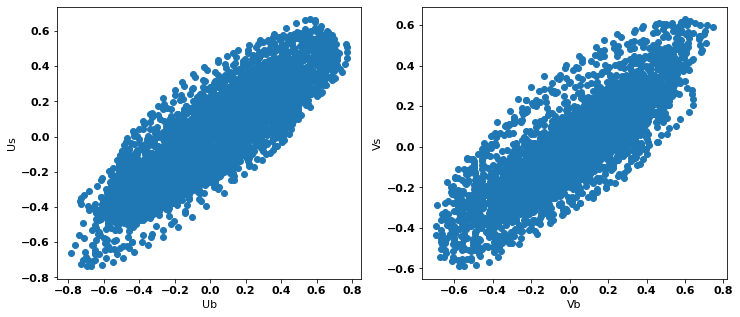

In [7]:
#scatter plot velocities.
fig=plt.figure(figsize=(12,5))
ax1=plt.subplot(1,2,1)
ax1.scatter(Ubres,Uts)
ax1.set_xlabel('Ub')
ax1.set_ylabel('Us')
ax2=plt.subplot(1,2,2)
ax2.scatter(Vbres,Vts)
ax2.set_xlabel('Vb')
ax2.set_ylabel('Vs')

The next set of blocks does the energy budget calculation.

In [8]:
def readmaindata(s,Bnum):
    bname='BUOY_'+Bnum
    Cwi=s['iCw'];Cai=s['iCa'];Cbi=s['iCb']
    g=s['g'];thetaa=s['thetaa']
    thetaw=s['thetaw'];rho_water=s['rho_water'];beta=s['beta']
    rho_air=s['rho_air']; rho_ice=s['rho_ice']
    locposfile='../../generated_data/'+bname
    D=pd.read_excel(locposfile+'/Pos_Vel_data.xlsx')
    return(bname,Cwi,Cai,Cbi,g,beta,rho_air,rho_ice,rho_water,D)
(bname,Cwi,Cai,Cbi,g,beta,rho_air,rho_ice,rho_water,D)=readmaindata(s,Bnum)

In [9]:
def readveldata(D,Uib,Vib,beta):
    numtaps=2*24*2+1
    fedge=int(numtaps/2)
    Ut=np.array(D['Ut']); Vt=np.array(D['Vt'])
    Ua=np.array(D['Ua']);Va=np.array(D['Va'])
    Uo=np.array(D['Uo']);Vo=np.array(D['Vo'])
    #filtered solutions for computing energy loss to tides.
    uit=Ubres;vit=Vbres
    #bathymetry
    Hvec=np.array(D['WDt'])
    Hvec=Hvec[fedge:-fedge]
    #transformation for rotation of Uw
    Ut=(Ut)*np.cos(beta)-(Vt)*np.sin(beta)
    Vt=(Ut)*np.sin(beta)+(Vt)*np.cos(beta)   
    Uw=Ut+Uo; Vw=Vt+Vo
    #sea ice velocities
    u=Uib;v=Vib
    #computation of modulus
    Ua_mag=np.sqrt((Ua-u)**2+(Va-v)**2)
    Uw_mag=np.sqrt((Uw-u)**2+(Vw-v)**2)
    return(u,v,Ut,Vt,Ua,Va,Uo,Vo,Uw,Vw,Vt,Hvec,uit,vit,Ua_mag,Uw_mag)
(u,v,Ut,Vt,Ua,Va,Uo,Vo,Uw,Vw,Vt,Hvec,uit,vit,Ua_mag,Uw_mag)=readveldata(D,Uib,Vib,beta)

In [10]:
def windenergy(u,v,Ua,Va):
    #energy  for wind stress  taua.ui
    #dot product of sea ice vel and air velocity
    prod=np.multiply(u,Ua-u)+np.multiply(v,Va-v)
    enerwinddt=Cai*rho_air*np.multiply(Ua_mag,prod)
    enerwindtraj=np.trapz(enerwinddt,dx=15*60)
    meanenerwind=np.mean(enerwinddt)
    stdenerwind=np.std(enerwinddt)
    print(enerwindtraj)
    print(meanenerwind)
    print(stdenerwind)
    return(enerwindtraj,meanenerwind,stdenerwind)
(enerwindtraj,meanenerwind,stdenerwind)=windenergy(u,v,Ua,Va)

51824.50761675187
0.01304123728339569
0.033910999893624505


In [11]:
def waterenergy(u,v,Uw,Vw):
    #energy loss for water stress  tauw.ui
    #dot product of sea ice vel and water velocity
    prod=np.multiply(u,Uw-u)+np.multiply(v,Vw-v)
    enerwaterdt=Cwi*rho_water*np.multiply(Uw_mag,prod)
    enerwatertraj=np.trapz(enerwaterdt,dx=15*60)
    meanenerwater=np.mean(enerwaterdt)
    stdenerwater=np.std(enerwaterdt)
    print(enerwatertraj)
    print(meanenerwater)
    print(stdenerwater)
    return(enerwatertraj,meanenerwater,stdenerwater)
(enerwatertraj,meanenerwater,stdenerwater)=waterenergy(u,v,Uw,Vw)

-527954.4086829133
-0.13286730895280718
0.22368116316210684


In [12]:
def tideenergy(uit,vit,Uts,Vts):
    #energy loss for tidal currents  taut.ui
    #dot product of sea ice vel and tidal velocity
    Ut_mag=np.sqrt((Uts-uit)**2+(Vts-vit)**2)
    prod=np.multiply(Uts-uit,Uts-uit)+np.multiply(Uts-uit,Vts-vit)
    enertidedt=-Cwi*rho_water*np.multiply(Ut_mag,prod)
    enertidetraj=np.trapz(enertidedt,dx=15*60)
    meanenertide=np.mean(enertidedt)
    stdenertide=np.std(enertidedt)
    print(enertidetraj)
    print(meanenertide)
    print(stdenertide)
    return(enertidetraj,meanenertide,stdenertide)
(enertidetraj,meanenertide,stdenertide)=tideenergy(uit,vit,Uts,Vts)

-185047.1450124221
-0.04766123102086869
0.10624301133726204


In [13]:
def bottomenergy(Uts,Vts):
    #energy loss of tides to bottom friction.
    Ub_mag=np.sqrt((Uts)**2+(Vts)**2)
    prod=np.multiply(Uts,Uts)+np.multiply(Vts,Vts)
    enerbottomdt=-Cbi*rho_water*np.multiply(Ub_mag,prod)
    enerbottomtraj=np.trapz(enerbottomdt,dx=15*60)
    meanenerbottom=np.mean(enerbottomdt)
    stdenerbottom=np.std(enerbottomdt)
    print(enerbottomtraj)
    print(meanenerbottom)
    print(stdenerbottom)
    return(enerbottomtraj,meanenerbottom,stdenerbottom)
(enerbottomtraj,meanenerbottom,stdenerbottom)=bottomenergy(Uts,Vts)

-337656.18129395775
-0.08685553946231307
0.10564810478424705


In [14]:
def ener2excel():
    #Saving the energy budget into energy budget excel
    Type=np.array(['Wind','Water','Tidal','Bottom'])
    traj=np.array([enerwindtraj,enerwatertraj,enertidetraj,enerbottomtraj])
    mean=np.array([meanenerwind,meanenerwater,meanenertide,meanenerbottom])
    std=np.array([stdenerwind,stdenerwater,stdenertide,stdenerbottom])
    writer = pd.ExcelWriter(loc+'/enerbudget_'+bname+'.xlsx',engine='xlsxwriter') 
    gf.valuewriter(writer,'Type',Type,'Sheet1',0,0)
    gf.valuewriter(writer,'Total_Energy(J/m^2)',traj,'Sheet1',1,0)
    gf.valuewriter(writer,'Mean_Energy(J/m^2s)',mean,'Sheet1',2,0)
    gf.valuewriter(writer,'Std_Energy(J/m^2s)',std,'Sheet1',3,0)
    writer.save()
ener2excel()

In [15]:
from IPython.core.display import display, HTML
HTML('''<script> </script> <form action="javascript:IPython.notebook.execute_cells_above()"><input type="submit" id="toggleButton" value="Run all"></form>''')

In [15]:
#iteration over the functions to plot. 
barray=['02','03','09','13','14','16'] 
barray=['16'] 
for b in barray:
    Bnum=b
    [s,SD,loc]=readdata(Bnum)
    [Uib,Vib,Uisvec,T]=genvelplots(SD,loc)
    FTplots(SD,loc,Bnum)
    (Usres,Vsres,Uts,Vts,Ubres,Vbres)=compnplotvelvect(SD,Bnum,loc,T)
    (bname,Cwi,Cai,Cbi,g,beta,rho_air,rho_ice,rho_water,D)=readmaindata(s,Bnum)
    (u,v,Ut,Vt,Ua,Va,Uo,Vo,Uw,Vw,Vt,Hvec,uit,vit,Ua_mag,Uw_mag)=readveldata(D,Uib,Vib,beta)
    (enerwindtraj,meanenerwind,stdenerwind)=windenergy(u,v,Ua,Va)
    (enerwatertraj,meanenerwater,stdenerwater)=waterenergy(u,v,Uw,Vw)
    (enertidetraj,meanenertide,stdenertide)=tideenergy(Usres,Vsres,Uts,Vts)
    (enerbottomtraj,meanenerbottom,stdenerbottom)=bottomenergy(Uts,Vts)
    ener2excel()

h1f1A1T1O1Po1Pt1Bf0


KeyboardInterrupt: 

In [40]:
def ampphM2(vec):
    Nft=len(vec);dt=15*60.0 #time difference in observations
    [am,ph,fvec,tvec]=gf.FFTsig(vec,Nft,dt)
    tvec=tvec/3600
    M2=12.42
    arg=(np.abs(tvec-M2)).argmin()
    M2amp=am[arg];M2ph=ph[arg]
    return(M2amp,M2ph)
#wind energy loss computation.
def enervects(u,v,Ut,Vt,Ua,Va):
    M2tim=12.42*3600
    #energy  for wind stress  taua.ui
    #dot product of sea ice vel and air velocity # Ua-u is total, Ua only is approx.
    Ua_mag=np.sqrt((Ua)**2+(Va)**2)
    prod=np.multiply(u,Ua)+np.multiply(v,Va)
    enertaua=Cai*rho_air*np.multiply(Ua_mag,prod)    
    enertauatraj=np.trapz(enertaua,dx=15*60)
    enertauamean=enertauatraj/M2tim
    #energy loss of tides to bottom friction.
    Ub_mag=np.sqrt((Ut)**2+(Vt)**2)
    prod=np.multiply(Ut,Ut)+np.multiply(Vt,Vt)
    enertaubvec=-Cbi*rho_water*np.multiply(Ub_mag,prod)
    enertaubtraj=np.trapz(enertaubvec,dx=15*60)
    enertaubmean=enertaubtraj/M2tim
    return(enertaua,enertaubvec,enertauamean,enertaubmean)

def enervectslinear(u,v,Ut,Vt,Ua,Va):
    M2tim=12.42*3600
    # linear stress loss google colab formula
    #vector of stress.
    Ua_mag=np.sqrt((Ua)**2+(Va)**2)
#     prod=np.multiply(u,1)+np.multiply(v,1)   
    term1x=-Cai*rho_air*np.multiply(Ua_mag,u)
    term1y=-Cai*rho_air*np.multiply(Ua_mag,v)
    commonbrac=np.multiply(Ua,v)-np.multiply(Va,u)
#     dotproduct=np.multiply(-Va,1)+np.multiply(Ua,1)
    term2x=Cai*rho_air*np.multiply(1/Ua_mag,np.multiply(-Va,commonbrac))
    term2y=Cai*rho_air*np.multiply(1/Ua_mag,np.multiply(Ua,commonbrac))
    tauavecx=2*term1x+term2x
    tauavecy=2*term1y+term2y
    (M2amptauax,M2phtauax)=ampphM2(tauavecx)
    (M2amptauay,M2phtauay)=ampphM2(tauavecx)
    enertauaM2=np.multiply(M2amptauax,u)+np.multiply(M2amptauay,v)
    enertaua=np.multiply(tauavecx,u)+np.multiply(tauavecy,v)
    enertauatraj=np.trapz(enertaua,dx=15*60)
    enertauamean=enertauatraj/M2tim
    enertauaM2traj=np.trapz(enertauaM2,dx=15*60)
    enertauaM2mean=enertauaM2traj/M2tim
    #energy loss of tides to bottom friction.
    Ub_mag=np.sqrt((Ut)**2+(Vt)**2)
    prod=np.multiply(Ut,Ut)+np.multiply(Vt,Vt)
    enertaubvec=-Cbi*rho_water*np.multiply(Ub_mag,prod)
    enertaubtraj=np.trapz(enertaubvec,dx=15*60)
    enertaubmean=enertaubtraj/M2tim
    return(enertaua,enertaubvec,enertauamean,enertauaM2mean,enertaubmean)
    
# (enerwindtraj,meanenerwind,stdenerwind)=constwindenergy(u,v,Ua,Va)\

In [41]:
# comparison of energy loss to wind for sea ice and bottom friction. 
# obtaining datasets.
barray=['02','03','09','13','14','16'] 
enerval={}
for b in barray:
    valam=[];valph=[];valmean=[]
    print("Running for buoy:"+b)
    airvec=np.power(2,[0,1,2,3,4,5])
    Bnum=b
    [s,SD,loc]=readdata(Bnum)
    [Uib,Vib,Uisvec,T]=genvelplots(SD,loc)
    # (Usres,Vsres,Uts,Vts,Ubres,Vbres)=compnplotvelvect(SD,Bnum,loc,T)
    (bname,Cwi,Cai,Cbi,g,beta,rho_air,rho_ice,rho_water,D)=readmaindata(s,Bnum)
    Usres=SD['Usres'];Vsres=SD['Vsres']
    Ubres=SD['Ubres'];Vbres=SD['Vbres']      
    (u,v,Ut,Vt,Ua,Va,Uo,Vo,Uw,Vw,Vt,Hvec,uit,vit,Ua_mag,Uw_mag)=readveldata(D,Uib,Vib,beta)
    Ua=1;Va=1
    numtaps=2*24*2+1
    fedge=int(numtaps/2)
    Ut=Ut[fedge:-fedge];Vt=Vt[fedge:-fedge]
#     Ua=Ua[fedge:-fedge];Va=Va[fedge:-fedge]
#     (enertauavec,enertaubvec,enertauamean,enertaubmean)=enervects(uit,vit,Ut,Vt,Ua,Va)
    (enertaua,enertaubvec,enertauamean,enertauaM2mean,enertaubmean)=enervectslinear(u,v,Ut,Vt,Ua,Va)
    print(np.shape(uit))
    print(np.shape(Ut))
    (M2amptaub,M2phtaub)=ampphM2(enertaubvec)
    valam=np.append(valam,M2amptaub)
    valph=np.append(valph,M2phtaub)
    valmean=np.append(valmean,enertaubmean)
    for a in airvec:
        Ua=np.sqrt(a**2/2);Va=np.sqrt(a**2/2)
#         (enertauavec,enertaubvec,enertauamean,enertaubmean)=enervects(uit,vit,Ut,Vt,Ua,Va)
        (enertaua,enertaubvec,enertauamean,enertauaM2mean,enertaubmean)=enervectslinear(u,v,Ut,Vt,Ua,Va)
#         (M2amptaua,M2phtaua)=ampphM2(enertauavec)
        (M2amptaua,M2phtaua)=ampphM2(enertaua)
        valam=np.append(valam,M2amptaua)
        valph=np.append(valph,M2phtaua)  
        valmean=np.append(valmean,enertauamean)
#         valmean=np.append(valmean,enertauaM2mean)
    val=np.column_stack((valam,valph,valmean))
    enerval.update({b:val})

Running for buoy:02
h1f1A1T1O1Po1Pt1Bf0
General Velocity plots done.
(1520,)
(1520,)
Running for buoy:03
h1f1A1T1O1Po1Pt1Bf0
General Velocity plots done.
(4320,)
(4320,)
Running for buoy:09
h1f1A1T1O1Po1Pt1Bf0
General Velocity plots done.
(1528,)
(1528,)
Running for buoy:13
h1f1A1T1O1Po1Pt1Bf0
General Velocity plots done.
(892,)
(892,)
Running for buoy:14
h1f1A1T1O1Po1Pt1Bf0
General Velocity plots done.
(504,)
(504,)
Running for buoy:16
h1f1A1T1O1Po1Pt1Bf0
General Velocity plots done.
(4320,)
(4320,)


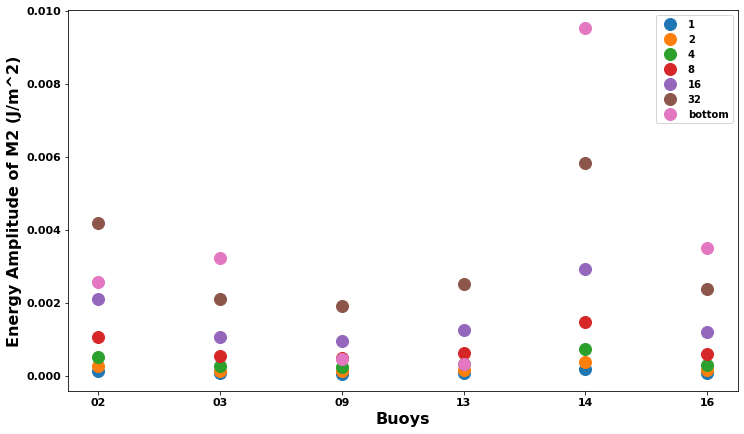

In [19]:
#plotting.
#plotting.
fig=plt.figure(figsize=(12,7),frameon=True)
i=1
for a in airvec:
    valb=[];vala=[]
    for b in barray:
        val=enerval[b]
        valb=np.append(valb,val[0,0])
        vala=np.append(vala,val[i,0])
    plt.plot(barray,vala, marker='o', linestyle='None',linewidth=2, markersize=12,label=a)
    i+=1
plt.plot(barray,valb, marker='o', linestyle='None',linewidth=2, markersize=12,label='bottom') 
plt.xlabel('Buoys',fontsize=16,fontweight='bold')
plt.ylabel('Energy Amplitude of M2 (J/m^2)',fontsize=16,fontweight='bold')
plt.legend(loc=1)   

In [61]:
#

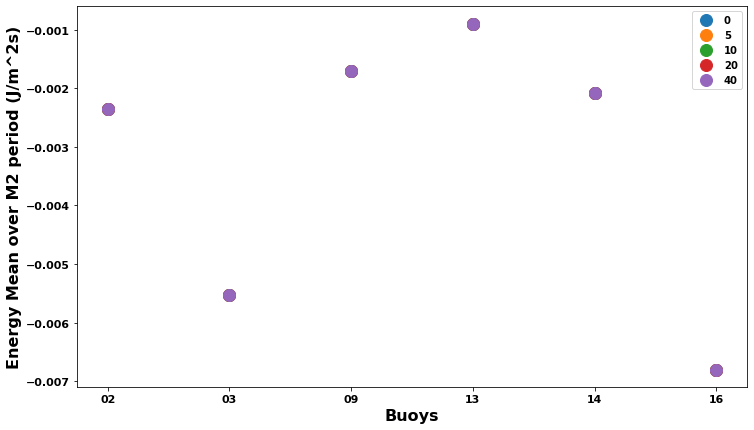

In [62]:
#plotting.
#plotting.
#plotting.
#plotting.
fig=plt.figure(figsize=(12,7),frameon=True)
i=1
for a in airvec:
    valb=[];vala=[]
    for b in barray:
        val=enerval[b]
        valb=np.append(valb,val[0,2])
        vala=np.append(vala,val[i,2])
    plt.plot(barray,vala, marker='o', linestyle='None',linewidth=2, markersize=12,label=a)
    i+=1
# plt.plot(barray,valb, marker='o', linestyle='None',linewidth=2, markersize=12,label='bottom') 
plt.xlabel('Buoys',fontsize=16,fontweight='bold')
plt.ylabel('Energy Mean over M2 period (J/m^2s)',fontsize=16,fontweight='bold')
plt.legend(loc=1)  
fig.savefig('mean_energy.png')

<Figure size 864x504 with 0 Axes>

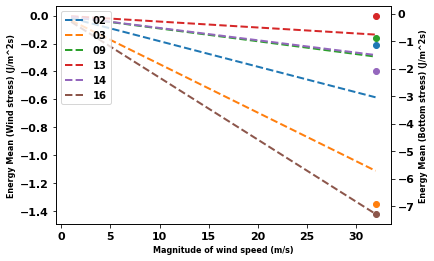

In [39]:
# plot of vel versus energy
fig=plt.figure(figsize=(12,7),frameon=True)
fig, ax=plt.subplots()
ax1=ax.twinx()
for b in barray:
    valb=[];vala=[]
    val=enerval[b]
    i=1
    valb=val[0,2]
    for a in airvec:                
        vala=np.append(vala,val[i,2])
        i+=1
    ax.plot(airvec,vala, linestyle='--',linewidth=2,label=b)
    ax1.plot(airvec[-1],valb,marker='o')
#     ax.annotate('%.2f' % valb,xy=[32,vala[5]+0.01])
#     plt.plot(0,valb,marker='*',markersize=16,label=b)    
# plt.plot(barray,valb, marker='o', linestyle='None',linewidth=2, markersize=12,label='bottom') 
ax.set_xlabel('Magnitude of wind speed (m/s)',fontsize='8',fontweight='bold')
ax.set_ylabel('Energy Mean (Wind stress) (J/m^2s)',fontsize='8',fontweight='bold')
ax.legend(loc=2)

ax1.set_ylabel('Energy Mean (Bottom stress) (J/m^2s)',fontsize='8',fontweight='bold')
xbottom=airvec[-1]*np.ones(len(barray))

fig.savefig('mean_energy_linearstress_noFT.png')

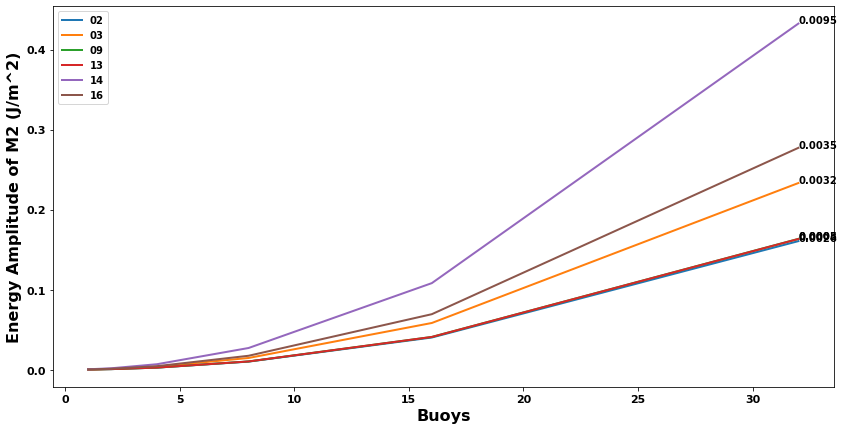

In [34]:
# plot of vel versus energy
fig=plt.figure(figsize=(14,7),frameon=True)
ax=plt.subplot(1,1,1)
for b in barray:
    valb=[];vala=[]
    val=enerval[b]
    i=1
    valb=val[0,0]
    for a in airvec:                
        vala=np.append(vala,val[i,0])
        i+=1
    ax.plot(airvec,vala, linestyle='-',linewidth=2,label=b)
    ax.annotate('%.4f' % valb,xy=[32,vala[5]])
#     plt.plot(0,valb,marker='*',markersize=16,label=b)    
# plt.plot(barray,valb, marker='o', linestyle='None',linewidth=2, markersize=12,label='bottom') 
plt.xlabel('Buoys',fontsize=16,fontweight='bold')
plt.ylabel('Energy Amplitude of M2 (J/m^2)',fontsize=16,fontweight='bold')
plt.legend(loc=2)
fig.savefig('amp_energy_total_stress.png')

In [106]:
#plot for uit-ut
midindex=288*7  #this is index for splitting the quiver plot. It varies per buoy.
ylim=0.9 #this is the y axis limit in the graph.
labelname=['gtsm','obs']
name='model-obs-obs'
fedge=int(2*24*2/2)
Tres=T[fedge:-fedge]
Coru=scipy.stats.pearsonr(Ubres,Ubres-Uts)
Corv=scipy.stats.pearsonr(Vbres,Vbres-Vts)
print(Coru,Corv)
plots.pltvelquiver('../',name,Tres,midindex,ylim,Ubres-Uts,Vbres-Vts,Ubres,Vbres,Coru,Corv,labelname)

NameError: name 'Uts' is not defined

In [ ]:
#plot for uit-ut
fig=plt.figure(figsize=(12,5))
ax=plt.subplot(1,2,1)
ax.plot(Ubres*(Uts-Ubres)**2,label='diff')
ax.plot(0.3*Uts**3,label='0.3*gtsm')
plt.legend(loc=1)
ax.set_xlabel('time')
ax.set_xlabel('U^3')
ax=plt.subplot(1,2,2)
ax.plot(Vbres*(Vts-Vbres)**2,label='diff')
ax.plot(0.3*Vts**3,label='0.3*gtsm')
ax.set_xlabel('time')
ax.set_xlabel('V^3')
plt.legend(loc=1)
# plt.savefig('../../generated_data/'+bname+'/pgdifflo0.12la0.01.jpg')
plt.show()
print(Ubres[-30:])
print(Uts-Ubres)

In [ ]:
#plot for uit-ut
fig=plt.figure(figsize=(12,5))
ax=plt.subplot(1,2,1)
ax.plot(Ubres*(Uts-Ubres)**2,label='diff')
ax.plot(0.3*Uts**3,label='0.3*gtsm')
plt.legend(loc=1)
ax.set_xlabel('time')
ax.set_xlabel('U^3')
ax=plt.subplot(1,2,2)
ax.plot(Vbres*(Vts-Vbres)**2,label='diff')
ax.plot(0.3*Vts**3,label='0.3*gtsm')
ax.set_xlabel('time')
ax.set_xlabel('V^3')
plt.legend(loc=1)
# plt.savefig('../../generated_data/'+bname+'/pgdifflo0.12la0.01.jpg')
plt.show()
print(Ubres[-30:])
print(Uts-Ubres)

In [ ]:
#iteration over the functions to get energy
barray=['02','03','09','13','14','16'] 
for b in barray:
    Bnum=b
    [s,SD,loc]=readdata(Bnum)
    [Uib,Vib,Uisvec,T]=genvelplots(SD,loc)
    (Usres,Vsres,Uts,Vts,Ubres,Vbres)=compnplotvelvect(SD,Bnum,loc,T)
    (bname,Cwi,Cai,Cbi,g,beta,rho_air,rho_ice,rho_water,D)=readmaindata(s,Bnum)
    (u,v,Ut,Vt,Ua,Va,Uo,Vo,Uw,Vw,Vt,Hvec,uit,vit,Ua_mag,Uw_mag)=readveldata(D,Uib,Vib,beta)
    (enerwindtraj,meanenerwind,stdenerwind)=windenergy(u,v,Ua,Va)
    (enerwatertraj,meanenerwater,stdenerwater)=waterenergy(u,v,Uw,Vw)
    (enertidetraj,meanenertide,stdenertide)=tideenergy(uit,vit,Uts,Vts)
    (enerbottomtraj,meanenerbottom,stdenerbottom)=bottomenergy(Uts,Vts)
    ener2excel()

In [ ]:
Bnum='16'
bname='BUOY_'+Bnum

In [ ]:
#Pressure gradients sensitivity.
locposvel='../../generated_data/'+bname+'/Pos_Vel_data.xlsx'
df=pd.read_excel(locposvel,'PGs')
df2=pd.read_excel(locposvel,'Sheet1')
Pgxt=df['Pgxt'];Pgyt=df['Pgyt']
Pgxtr=df['Pgxtr'];Pgytr=df['Pgytr']
Pgxtl=df['Pgxtl'];Pgytl=df['Pgytl']
Fgxt=df2['Fpgx'];Fgyt=df2['Fpgy']
H=df2['WDt'];h=df2['ssht']
Hb=H-h

diffx_fg=Pgxt-Fgxt;diffy_fg=Pgyt-Fgyt
diffx=((Pgxtr-Pgxtl));diffy=abs((Pgytr-Pgytl))
print((diffx))

In [ ]:
Uog=df2['Uog'];Vog=df2['Vog']
Ut=df2['Ut'];Vt=df2['Vt']
Uib=df2['Uib'];Ua=df2['Ua'];Uo=df2['Uo']
Vib=df2['Vib']
Uamag=np.sqrt(Ua**2+Va**2)

In [ ]:
import runningmodel as rm
(XD,YD)=rm.statscompute(s,Ua,Va,Uib,Vib)

In [ ]:
Uafil=XD['Xofil'];Vafil=YD['Yofil']
edge=int(2*24*2/2)
Uares=Ua[edge:-edge]-Uafil
Vares=Va[edge:-edge]-Vafil
plt.plot(Vares)
# plt.plot(Ut)
Tft=SD['Tft']
argtide=SD['tidearg'];argcor=SD['corarg']
argval=np.append(Tft[argtide],Tft[argcor])
# X and Y amplitudes (lon and lat)
units='deg'
plots.pltFT('',Bnum+'UaFT',XD['Xoft'],XD['Xoft'],units,Tft,argval)

In [ ]:
llim=0;ulim=-1
fig=plt.figure(figsize=(12,5))
ax=plt.subplot(1,2,1)
ax.plot(Pgxt[llim:ulim],label='CDg')
ax.plot(Fgxt[llim:ulim],label='CDf')
# ax.plot(Pgxtr,label='FD')
# ax.plot(Pgxtl,label='BD')
# ax.plot(diffx[llim:ulim],label='sens')
# ax.plot(diffx_fg[llim:ulim],label='g-f')
plt.legend(loc=1)
ax=plt.subplot(1,2,2)
ax.plot(Pgyt[llim:ulim],label='CDg')
ax.plot(Fgyt[llim:ulim],label='CDf')
# ax.plot(Pgytr,label='FD')
# ax.plot(Pgytl,label='BD')
# ax.plot(diffy[llim:ulim]*100,label='sens')
# ax.plot(diffy_fg[llim:ulim],label='g-f')
plt.legend(loc=1)
# plt.savefig('../../generated_data/'+bname+'/pgdifflo0.12la0.01.jpg')
plt.show()

In [ ]:
#compute gradient of water depth. 
Xib=df2['Xib'];Yib=df2['Yib']
dHdxvec=[];dHdyvec=[];
for j in range(len(Xib)-1):
    dlon=Xib[j+1]-Xib[j]
    dlat=Yib[j+1]-Yib[j]
    dH=H[j+1]-H[j]
    lat=Yib[j];lon=Xib[j]
    dlatm=111.32e03*dlat;dlonm=111.32e03*dlon/4.
    dHdx=dH/dlonm;dHdy=dH/dlatm
    dHdxvec=np.append(dHdxvec,dHdx)
    dHdyvec=np.append(dHdyvec,dHdy)

In [38]:
#mean of sin
A=4
t=np.linspace(0,2*np.pi,100)
w=A*np.sin(t)
np.mean(w)

-6.308787957518634e-17

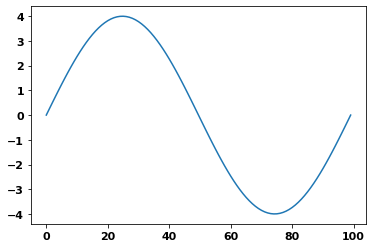

In [39]:
plt.plot(w)